### 환경 설정

In [1]:
# API 키를 환경변수로 관리하기 위한 설정 파일
from dotenv import load_dotenv

# API 키 정보 로드
load_dotenv()

True

In [2]:
# LangSmith 추적을 설정합니다. https://smith.langchain.com
# !pip install -qU langchain-teddynote
from langchain_teddynote import logging

# 프로젝트 이름을 입력합니다.
logging.langsmith("Secretfriend Workflow - 모듈화 TEST")

LangSmith 추적을 시작합니다.
[프로젝트명]
Secretfriend Workflow - 모듈화 TEST


### LLM

In [3]:
from agents import *
from langchain_openai import ChatOpenAI
from langchain_teddynote.models import get_model_name, LLMs

# LLM 초기화
MODEL_NAME = get_model_name(LLMs.GPT4o)
llm = ChatOpenAI(temperature=0, model=MODEL_NAME)

### Agents

In [4]:
from langchain.agents import create_tool_calling_agent
from langchain.agents import AgentExecutor
from langchain_core.output_parsers import PydanticOutputParser

music_parser = PydanticOutputParser(pydantic_object=MusicResponse)

music_tools = [SpotifyTool()]

music_agent = create_tool_calling_agent(
    llm=llm,
    tools=music_tools,
    prompt=get_music_prompt(music_parser.get_format_instructions())
)

# Music AgentExecutor 생성
music_agent_executor = AgentExecutor(agent=music_agent, tools=music_tools, verbose=True)

In [5]:
quote_parser = PydanticOutputParser(pydantic_object=QuoteResponse)

quote_tools = [create_web_search_tool()]

quote_agent = create_tool_calling_agent(
    llm=llm,
    tools=quote_tools,
    prompt=get_quote_prompt(quote_parser.get_format_instructions())
)

# Quote AgentExecutor 생성
quote_agent_executor = AgentExecutor(agent=quote_agent, tools=quote_tools, verbose=True)

### 그래프 생성

In [6]:
from langgraph.graph import END, StateGraph, START

# 그래프 생성
letter_workflow = StateGraph(SecretFriendState)

letter_workflow.add_node("start_node_check", StartNodeCheck())
letter_workflow.add_edge(START, "start_node_check")
letter_workflow.add_node("music", MusicRecommendationNode(music_agent_executor))
letter_workflow.add_node("quote", QuoteRecommendationNode(quote_agent_executor))
letter_workflow.add_node("praise", PraiseNode(llm))
letter_workflow.add_node("mbti_feedback", MBTIFeedbackNode(llm))
letter_workflow.add_node("letter_markdown", LetterMarkdownNode())


# 노드 연결
letter_workflow.add_edge("start_node_check", "music")
letter_workflow.add_edge("start_node_check", "quote")
letter_workflow.add_edge("start_node_check", "praise")
letter_workflow.add_edge("start_node_check", "mbti_feedback")
letter_workflow.add_edge("music", "letter_markdown")
letter_workflow.add_edge("quote", "letter_markdown")
letter_workflow.add_edge("praise", "letter_markdown")
letter_workflow.add_edge("mbti_feedback", "letter_markdown")
letter_workflow.add_edge("letter_markdown", END)


# 그래프 컴파일
letter_graph = letter_workflow.compile()

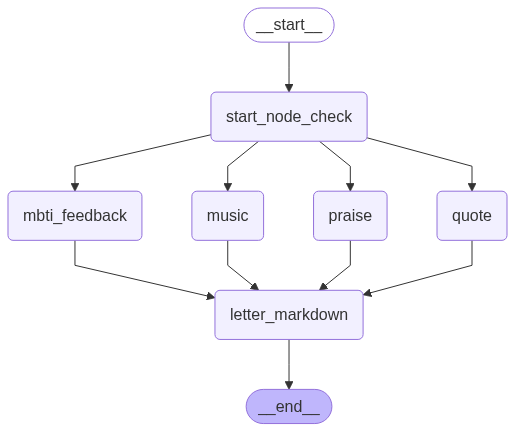

In [7]:
from IPython.display import Image, display

display(Image(letter_graph.get_graph().draw_mermaid_png()))

In [8]:
import uuid

config = {"configurable": {"thread_id": str(uuid.uuid4())}}
test_state = {
    'diary_body': """오늘 아침, 나는 오랜만에 조깅을 나갔다. 해가 떠오르기 시작한 시간, 6시. 아침 햇살이 너무 예뻐서 기분이 좋았다. 바람은 선선하고, 몸은 가벼워서 상쾌한 기분이 들었다. 조깅을 하면서 느끼는 그 홀가분한 감정은 언제나 나를 행복하게 만든다. 오늘은 특히나 기분이 좋았다. 아침 시간을 나를 위해 쓴 것 같아 뿌듯함이 느껴졌다. 하지만 운동화를 바꿔야 할 것 같다는 생각이 들었다. 발이 살짝 아팠거든.

오후가 되어 2시 반, 나는 프로젝트 발표를 준비했다. 동료 유재석과 함께한 이 프로젝트는 나에게 많은 의미가 있었다. 발표 전에는 심장이 너무 뛰어서 손까지 떨렸다. 긴장감이 가득했지만, 막상 말하기 시작하니 점점 긴장이 풀렸다. 준비했던 내용을 자연스럽게 전달할 수 있었고, 그 순간의 안도감은 이루 말할 수 없었다. 많이 떨렸지만, 결국 잘 해내서 다행이라는 생각이 들었다. 진심을 담은 설명은 꼭 완벽하지 않아도 전달된다는 것을 느꼈다.

저녁 8시, 나는 첫눈을 보았다. 언제나처럼 첫눈을 보면 기분이 좋아진다. 코끝도, 손도, 발도 시렸지만, 마음은 포근했다. 바쁘게 흘러가는 일상 속에서 잠깐 멈춰서 첫눈을 즐기며 마음을 느낄 수 있었다. 그 순간, 세상의 모든 것이 멈춘 듯한 기분이 들었다. 오늘 하루는 이렇게 기쁨과 두려움, 설렘이 가득한 하루였다. 아침의 상쾌함, 발표의 긴장감, 그리고 첫눈의 포근함이 어우러져 나에게 특별한 하루를 선사해주었다.
    """
}

result = letter_graph.invoke(test_state)



> Entering new AgentExecutor chain...


> Entering new AgentExecutor chain...

Invoking: `tavily_search` with `{'query': '행복 명언', 'search_depth': 'basic'}`



Invoking: `spotify_recommender_tool` with `{'diary': '오늘 아침, 나는 오랜만에 조깅을 나갔다. 해가 떠오르기 시작한 시간, 6시. 아침 햇살이 너무 예뻐서 기분이 좋았다. 바람은 선선하고, 몸은 가벼워서 상쾌한 기분이 들었다. 조깅을 하면서 느끼는 그 홀가분한 감정은 언제나 나를 행복하게 만든다. 오늘은 특히나 기분이 좋았다. 아침 시간을 나를 위해 쓴 것 같아 뿌듯함이 느껴졌다. 하지만 운동화를 바꿔야 할 것 같다는 생각이 들었다. 발이 살짝 아팠거든.\n\n오후가 되어 2시 반, 나는 프로젝트 발표를 준비했다. 동료 유재석과 함께한 이 프로젝트는 나에게 많은 의미가 있었다. 발표 전에는 심장이 너무 뛰어서 손까지 떨렸다. 긴장감이 가득했지만, 막상 말하기 시작하니 점점 긴장이 풀렸다. 준비했던 내용을 자연스럽게 전달할 수 있었고, 그 순간의 안도감은 이루 말할 수 없었다. 많이 떨렸지만, 결국 잘 해내서 다행이라는 생각이 들었다. 진심을 담은 설명은 꼭 완벽하지 않아도 전달된다는 것을 느꼈다.\n\n저녁 8시, 나는 첫눈을 보았다. 언제나처럼 첫눈을 보면 기분이 좋아진다. 코끝도, 손도, 발도 시렸지만, 마음은 포근했다. 바쁘게 흘러가는 일상 속에서 잠깐 멈춰서 첫눈을 즐기며 마음을 느낄 수 있었다. 그 순간, 세상의 모든 것이 멈춘 듯한 기분이 들었다. 오늘 하루는 이렇게 기쁨과 두려움, 설렘이 가득한 하루였다. 아침의 상쾌함, 발표의 긴장감, 그리고 첫눈의 포근함이 어우러져 나에게 특별한 하루를 선사해주었다.', 'keyword': '첫눈'}`


제목은 [First Snow], 가수는 [BrokenTeeth], url은 [h

In [9]:
from IPython.display import Markdown

display(Markdown(result['letter_markdown']))

# 💌 비밀친구의 편지

너를 위해 작지만 따뜻한 편지를 준비했어.

---

## 🌟 오늘의 칭찬

> 와, 너 오늘 아침에 6시에 일어나서 조깅한 거 진짜 대단한 거 알지? 아침 햇살 받으면서 상쾌하게 뛰었다니, 그거 완전 인생의 승리자 아니냐! 너의 그 부지런함과 자기 관리 능력, 진짜 존경스럽고 멋져! 🌟

---

## 🎵 오늘의 음악 추천

**First Snow** - *BrokenTeeth*  
🔗 [음악 들으러 가기](https://open.spotify.com/track/3vJpDylX1JKpHVOJA5vCFl)  
_👉 첫눈을 보면서 느꼈던 그 포근한 기분을 음악으로도 느껴봐. 오늘 하루의 특별함을 더해줄 거야._

---

## 📝 오늘의 명언

> “행복은 사소한 일에서 곧바로 즐거움을 알아채는 것이다.”  
> — *휴 월폴*  
오늘 하루는 정말 특별한 순간들로 가득했네. 아침 조깅의 상쾌함, 프로젝트 발표의 긴장감, 그리고 첫눈의 포근함까지. 이런 작은 순간들이 모여서 큰 행복을 만들어주는 것 같아. 휴 월폴의 말처럼, 사소한 일에서 즐거움을 찾는 것이 진정한 행복이 아닐까 싶어. 너의 하루가 그런 작은 행복들로 가득 차 있어서 나도 기뻐!

---

## 🌷 F의 위로

오늘 하루 정말 특별했겠다! 아침 조깅하면서 느낀 상쾌함과 뿌듯함, 그리고 프로젝트 발표의 긴장감 속에서도 잘 해낸 너의 모습이 정말 대단해. 준비한 만큼 자연스럽게 전달할 수 있었다니, 그 순간의 안도감이 얼마나 컸을지 상상이 가. 그리고 첫눈을 보며 잠시 멈춰서 마음을 느낄 수 있었다니, 그 포근한 순간이 너에게 큰 위로가 되었을 것 같아. 발이 살짝 아팠던 건 아쉽지만, 그럼에도 불구하고 하루를 잘 견뎌낸 너에게 박수를 보내고 싶어. 오늘의 감정들을 소중히 간직하고, 앞으로도 너만의 특별한 순간들을 많이 만들어가길 바랄게.

---

## 🧭 T의 조언

조깅하면서 느낀 상쾌함과 발표를 잘 마친 성취감, 그리고 첫눈의 포근함까지, 오늘 하루 정말 알차게 보냈네! 운동화가 발에 불편했다면, 조깅을 더 즐겁게 하기 위해서라도 빨리 새 운동화를 준비하는 게 좋을 것 같아. 발이 편해야 더 오래, 더 자주 조깅할 수 있으니까. 그리고 발표 준비하면서 느낀 긴장감은 누구나 겪는 거니까 너무 걱정하지 마. 다음번에는 발표 전에 심호흡을 하거나 간단한 스트레칭을 해보는 것도 도움이 될 거야. 오늘처럼 다양한 감정을 느끼면서 하루를 보낸 건 정말 멋진 일이야. 앞으로도 이런 순간들을 많이 만들어가길 바랄게!

---

비밀친구가 여기 있다는 걸 잊지 마.  
내일도 네 편이 되어줄게.

다 잘 될 거야! ☁️
잘 자.

— 너의 비밀친구가 -
